# Парсер HeadHunter
## Цель:
* Сделать парсер для выборки вакансий по актуальным критериям (в этом примере сделана выборка вакансий аналитиков данных с неполной занятостью и удаленные);
* Настроить удобный просмотр, анализ зарплат, рейтинг работодателей.

## Какие библиотеки и инструменты будем использовать?
* requests - для отправки запросов к API HH
* pandas - для формирования таблицы 
* matplotlib, seaborn - визуализация
* json - формат обмена данными, будем использовать для декодирования ответов в удобном формате
* IPython - для магических штук
* BeautifulSoup - библиотека Python для извлечения данных из файлов HTML и XML

### Импорт библиотек

In [2]:
import requests
import pandas as pd
import numpy as np

import json

from datetime import datetime, timedelta
import time
import os
from IPython.core.display import display, HTML, clear_output
import ipywidgets as widgets
from typing import Union

import matplotlib.pyplot as plt
import seaborn as sns

### Делаем выгрузку из HeadHunter
Ссылка на API HH: https://github.com/hhru/api \
Для того, чтобы написать запрос используется язык поисковых запросов, задокументированный тут: https://hh.ru/article/1175 \
Фильтрацию можно делать в самом запросе, например, сделать поиск по полю компаний или же по наличию конкретного текста в описании, где COMPANY_NAME - название компании, а DESCRIPTION - описание вакансии. Язык запросов работает и на обычном сайте hh.ru, что бывает полезно.

Создадим необходимые константы: BASE_URL

In [2]:
BASE_URL = "https://api.hh.ru/"

TEXT = f'SQL NAME:("Аналитик" or "Analyst" or "DWH" or "BI" or "Business Intelligence" or "ETL" or "КХД")'

dt_now = datetime.now().date()
dt_from = dt_now - timedelta(days=7)
DATE_TO = dt_now.isoformat() #API требует дату в формате ISO 8601 YYYY-MM-DD или YYYY-MM-DDThh:mm:ss±hhmm
DATE_FROM = dt_from.isoformat()

VAC_URL = (BASE_URL + 
           f'vacancies?text={TEXT}&date_from={DATE_FROM}&date_to={DATE_TO}&responses_count_enabled=True&per_page=100'
)

In [3]:
vacancy_df = pd.DataFrame() # создаем датафрейм в который будем сохранять наши данные

В выдаче API HH нет опыта работы, поэтому мы укажем его в запросе самостоятельно, чтобы потом делать отборы:

In [4]:
experiences = ['noExperience',
               'between1And3',
               'between3And6', 
               'moreThan6']

Напишем цикл для направления запросов к API

In [5]:
for exp in experiences:
    page = 0
    url = VAC_URL + f'&experience={exp}'
    try:
        r = requests.get(url + f'&page={page}')
        data = json.loads(r.text)
        print(exp, ' - ', data['pages'])
        items = data['items']
        for page in range(1,data['pages']):
            r = requests.get(url + f'&page={page}')
            data = json.loads(r.text)
            items += data['items']
        df = pd.DataFrame(items)
        df['experience'] = exp
        vacancy_df = pd.concat([vacancy_df,df])
    except Exception as e:
        print(exp, ' - ', e)
        time.sleep(5)

noExperience  -  3
between1And3  -  20
between3And6  -  10
moreThan6  -  1


In [6]:
vacancy_df.reset_index(drop=True, inplace=True)

In [7]:
vacancy_df.duplicated('id').sum()

29

Кстати, всё-время есть дубликаты по айдишникам вакансии. 

In [8]:
vacancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3250 entries, 0 to 3249
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        3250 non-null   object
 1   premium                   3250 non-null   bool  
 2   name                      3250 non-null   object
 3   department                431 non-null    object
 4   has_test                  3250 non-null   bool  
 5   response_letter_required  3250 non-null   bool  
 6   area                      3250 non-null   object
 7   salary                    630 non-null    object
 8   type                      3250 non-null   object
 9   address                   1620 non-null   object
 10  response_url              0 non-null      object
 11  sort_point_distance       0 non-null      object
 12  published_at              3250 non-null   object
 13  created_at                3250 non-null   object
 14  archived                

Смотрю, что лежит в ячейках столбца schedule. Питон ругается, но всё-равно показывает:

In [34]:
vacancy_df['schedule'].value_counts()

TypeError: unhashable type: 'dict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'dict'


{'id': 'fullDay', 'name': 'Полный день'}           2374
{'id': 'remote', 'name': 'Удаленная работа'}        758
{'id': 'flexible', 'name': 'Гибкий график'}         111
{'id': 'shift', 'name': 'Сменный график'}             6
{'id': 'flyInFlyOut', 'name': 'Вахтовый метод'}       1
Name: schedule, dtype: int64

На этом этапе я снова выкачиваю все вакансии, теперь делаю цикл по видам занятости:

In [35]:
employment = ["full",
              "part",
              "project",
              "volunteer",
              "probation"]

In [36]:
vacancy_df2 = pd.DataFrame()

In [37]:
for emp in employment:
    page = 0
    url = VAC_URL + f'&employment={emp}'
    try:
        r = requests.get(url + f'&page={page}')
        data = json.loads(r.text)
        print(emp, ' - ', data['pages'])
        items = data['items']
        for page in range(1,data['pages']):
            r = requests.get(url + f'&page={page}')
            data = json.loads(r.text)
            items += data['items']
        df = pd.DataFrame(items)
        df['employment'] = emp
        vacancy_df2 = pd.concat([vacancy_df2,df])
    except Exception as e:
        print(emp, ' - ', e)
        time.sleep(5)

full  -  20
part  -  1
project  -  1
volunteer  -  1
probation  -  1


In [38]:
vacancy_df2['id'] = vacancy_df2['id'].astype('int64')
vacancy_df['id'] = vacancy_df['id'].astype('int64')

обрежу во втором датафрейме все столбцы кроме нужной мне занятости

In [39]:
vacancy_df2 = vacancy_df2[['id','employment']]

In [40]:
vacancy_df2.head()

,id,employment
0,52327154,full
1,52130534,full
2,52337607,full
3,52321521,full
4,46630220,full


и мержу два датафрейма по айди вакансий

In [41]:
vacancy_df = vacancy_df.merge(vacancy_df2, on='id', how='left')

In [42]:
vacancy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3263 entries, 0 to 3262
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        3263 non-null   int64 
 1   premium                   3263 non-null   bool  
 2   name                      3263 non-null   object
 3   department                431 non-null    object
 4   has_test                  3263 non-null   bool  
 5   response_letter_required  3263 non-null   bool  
 6   area                      3263 non-null   object
 7   salary                    632 non-null    object
 8   type                      3263 non-null   object
 9   address                   1628 non-null   object
 10  response_url              0 non-null      object
 11  sort_point_distance       0 non-null      object
 12  published_at              3263 non-null   object
 13  created_at                3263 non-null   object
 14  archived                

### Вытащим ценную информацию из словарей

In [43]:
def return_id(x, key='id', nan_value = np.nan):
    try:
        return x[key]
    except Exception as e:
        return nan_value

In [44]:
vacancy_df['employer_name'] = vacancy_df['employer'].apply(return_id, key='name')
vacancy_df['department_name'] = vacancy_df['department'].apply(return_id, key='name')
vacancy_df['salary_from'] = vacancy_df['salary'].apply(return_id, key='from')
vacancy_df['salary_to'] = vacancy_df['salary'].apply(return_id, key='to')
vacancy_df['salary_gross'] = vacancy_df['salary'].apply(return_id, key='gross')
vacancy_df['salary_currency'] = vacancy_df['salary'].apply(return_id, key='currency')
vacancy_df['responses'] = vacancy_df['counters'].apply(return_id, key='responses')
vacancy_df['city'] = vacancy_df['area'].apply(return_id, key='name')
vacancy_df['schedule_type'] = vacancy_df['schedule'].apply(return_id, key='id')

Лишние столбцы удаляю

In [45]:
vacancy_df.drop(
    columns = ['type', 'contacts', 'premium','response_url',
               'sort_point_distance','relations','employer','schedule','department'], inplace=True)

In [46]:
vacancy_df.head(1).T

,0
id,49832942
name,Аналитик
has_test,False
response_letter_required,False
area,"{'id': '1', 'name': 'Москва', 'url': 'https://..."
salary,None
address,None
published_at,2022-02-11T13:26:27+0300
created_at,2022-02-11T13:26:27+0300
archived,False


### Про дубликаты

In [47]:
vacancy_df[vacancy_df.duplicated(['employer_name','name','city'], 
                                 keep=False)][['employer_name','name','city','experience']].sort_values(by=['name'])

,employer_name,name,city,experience
1810,Велес,BI Developer,Сочи,between1And3
1956,Велес,BI Developer,Сочи,between1And3
1955,Frontier KZ,BI engineer,Алматы,between1And3
1809,Frontier KZ,BI engineer,Алматы,between1And3
1952,НМЖК группа компаний,BI Разработчик/BI Developer,Нижний Новгород,between1And3
...,...,...,...,...
445,"Иннотех, Группа компаний",Финансовый аналитик (Источники данных),Москва,between1And3
340,"Иннотех, Группа компаний",Финансовый аналитик (Источники данных),Москва,between1And3
2749,Первый Украинский Международный банк,Фінансовий аналітик,Киев,between3And6
1555,Первый Украинский Международный банк,Фінансовий аналітик,Киев,between1And3


In [48]:
vacancy_df.duplicated(['employer_name','name','city','experience']).sum()

108

In [49]:
vacancy_df.duplicated(['id']).sum()

42

В выгрузке довольно много дубликатов вакансий, которые при пристальном рассмотрении отличаются незначительными деталями (город, требование к опыту).

удалю дублирующие айдишники

In [50]:
vacancy_df.drop_duplicates(subset='id',inplace=True)

In [51]:
#vacancy_df.loc[[4155,2155]]

### Посмотрим компании, предлагающие вакансии, а также города

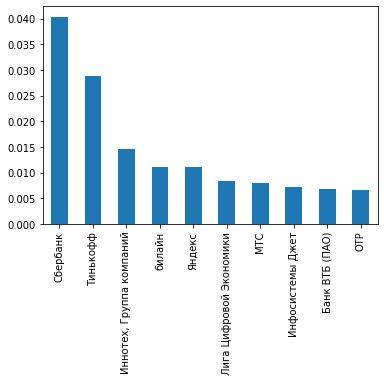

In [52]:
vacancy_df['employer_name'].value_counts(normalize=True).head(10).plot(kind='bar');

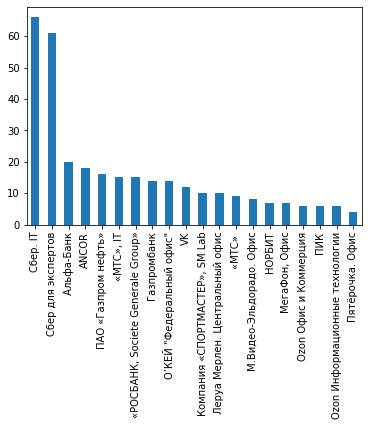

In [53]:
vacancy_df['department_name'].value_counts().head(20).plot(kind='bar');

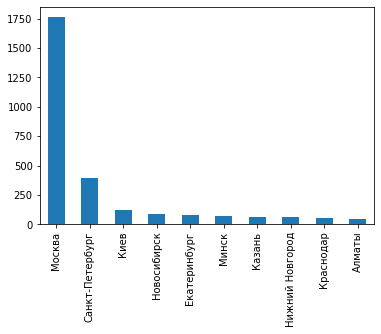

In [54]:
vacancy_df['city'].value_counts().head(10).plot(kind='bar');

### Что с зарплатой?

In [55]:
vacancy_df['salary_from'].isna().value_counts(normalize=True)

True     0.837318
False    0.162682
Name: salary_from, dtype: float64

In [56]:
vacancy_df['salary_to'].isna().value_counts(normalize=True)

True     0.886371
False    0.113629
Name: salary_to, dtype: float64

В большинстве вакансий зарплата не указана (83-88%)

In [57]:
vacancy_df['salary_currency'].value_counts(normalize=True)

RUR    0.920382
USD    0.046178
KZT    0.014331
EUR    0.006369
UAH    0.006369
UZS    0.003185
KGS    0.001592
BYR    0.001592
Name: salary_currency, dtype: float64

In [58]:
salaries = vacancy_df.query(
    "salary_currency == 'RUR' and experience in ['noExperience','between1And3']").groupby(
    ['employer_name','department_name']).mean()['salary_from'].reset_index()

In [59]:
salaries

,employer_name,department_name,salary_from
0,ANCOR,ANCOR,54787.500000
1,Avilon Group,ГК «Авилон»,190000.000000
2,HeadHunter,HeadHunter:: IT,170000.000000
3,Альфа-Банк,Альфа-Банк,NaN
4,"ВЕРНЫЙ, Сеть магазинов",Верный,NaN
5,"Лента, федеральная розничная сеть","Лента, федеральная розничная сеть, Офис",NaN
6,Леруа Мерлен,Леруа Мерлен. Центральный офис,45000.000000
7,Пятёрочка,Пятёрочка. Офис,50000.000000
8,Сбербанк,Сбер для экспертов,70000.000000
9,Сбербанк,Сбер. IT,116666.666667


Вот сводная по указанным зарплатам - можно примерно прикинуть диапазон.

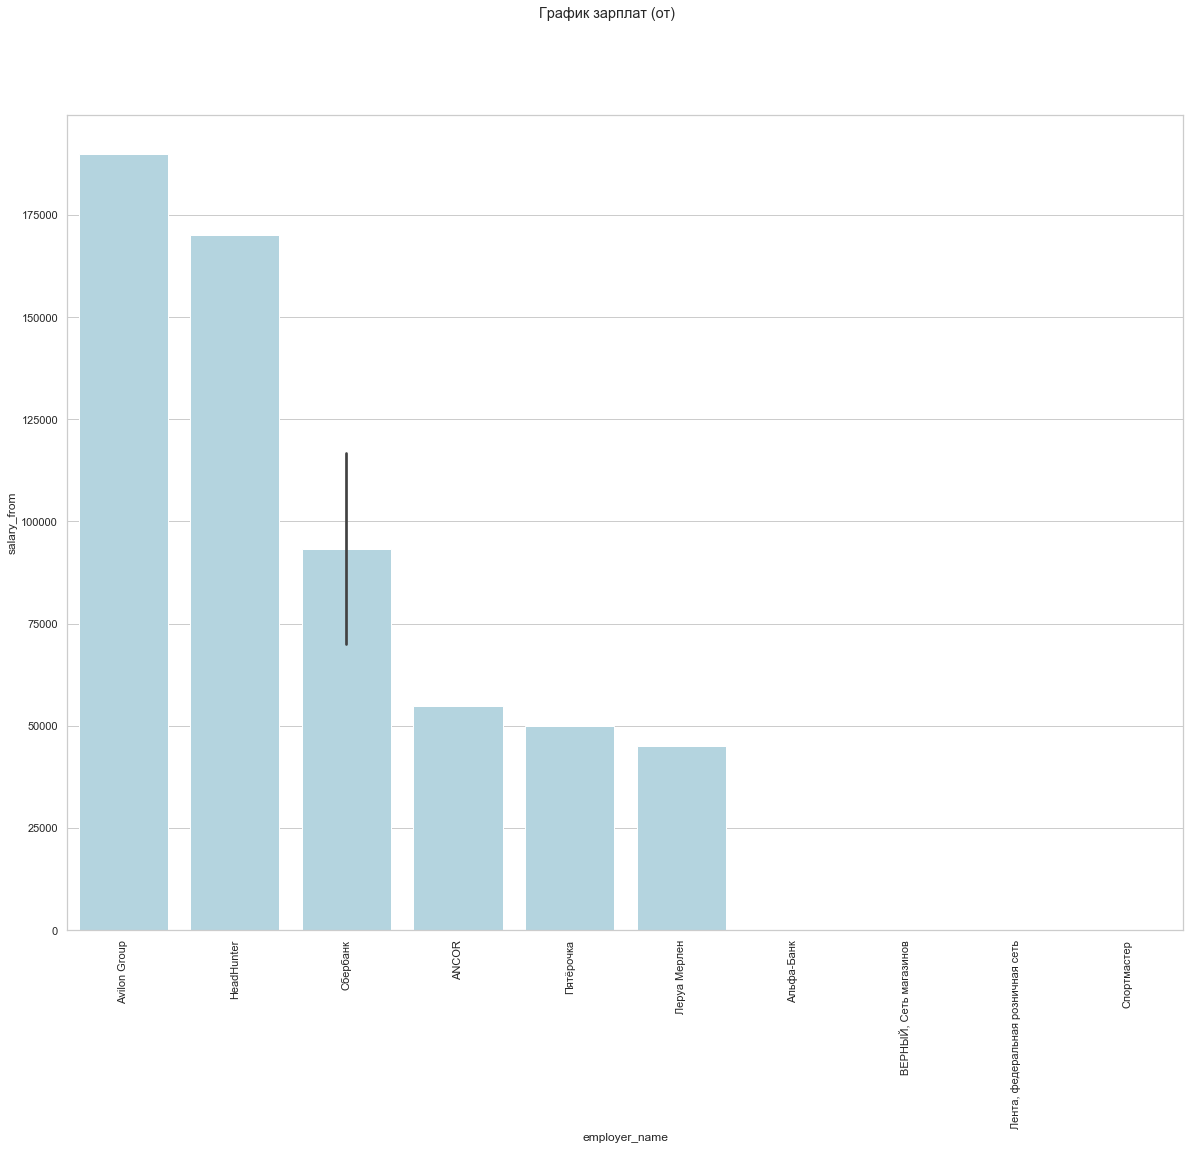

In [60]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20,15))                
title = 'График зарплат (от)'
fig.suptitle(title)
plt.xticks(rotation=90)  
sns.barplot(data=salaries.
            sort_values(by='salary_from', ascending=False), 
            x='employer_name', y='salary_from', color='lightblue', ax=ax);

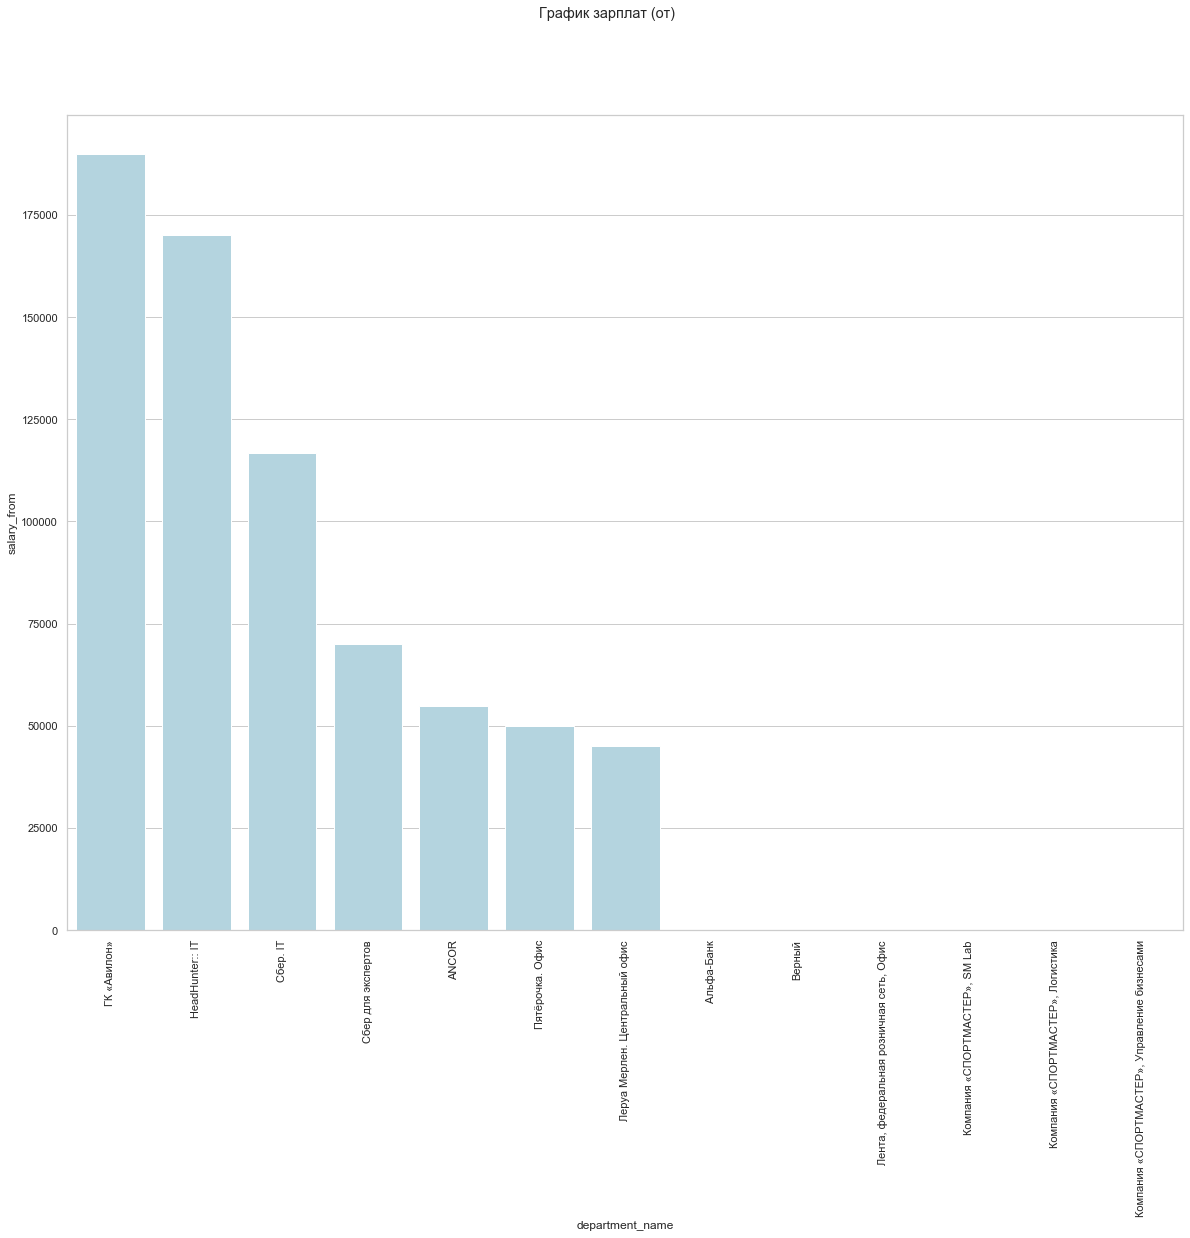

In [61]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20,15))                
title = 'График зарплат (от)'
fig.suptitle(title)
plt.xticks(rotation=90)  
sns.barplot(
    data=salaries.sort_values(by='salary_from', ascending=False), 
    x='department_name', y='salary_from', color='lightblue', ax=ax);

### Отбор по работодателю

In [62]:
vacancy_df['employer_name'].value_counts()

Сбербанк                    130
Тинькофф                     93
Иннотех, Группа компаний     47
билайн                       36
Яндекс                       36
                           ... 
Coral Travel                  1
Остров Мечты                  1
Ника                          1
Подружка, сеть магазинов      1
Abbott Laboratories           1
Name: employer_name, Length: 1311, dtype: int64

In [63]:
vacancy_df.dropna(
    subset=['employer_name', 'salary_from'])[vacancy_df['employer_name'].str.lower().str.contains('сбербанк')]

<ipython-input-63-d6e1157a5447>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vacancy_df.dropna(


,id,name,has_test,response_letter_required,area,salary,address,published_at,created_at,archived,...,employment,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,responses,city,schedule_type
168,52289416,ETL разработчик,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...","{'from': 70000, 'to': None, 'currency': 'RUR',...",None,2022-02-10T13:59:16+0300,2022-02-10T13:59:16+0300,False,...,NaN,Сбербанк,Сбер для экспертов,70000.0,NaN,False,RUR,3,Новосибирск,fullDay
185,51019102,Аналитик (Data science),False,False,"{'id': '102', 'name': 'Хабаровск', 'url': 'htt...","{'from': 50000, 'to': None, 'currency': 'RUR',...",None,2022-02-07T09:25:59+0300,2022-02-07T09:25:59+0300,False,...,part,Сбербанк,Сбер. IT,50000.0,NaN,False,RUR,1,Хабаровск,fullDay
196,50767550,Ведущий системный аналитик,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'from': 150000, 'to': None, 'currency': 'RUR'...","{'city': 'Санкт-Петербург', 'street': '4 линия...",2022-02-10T15:25:36+0300,2022-02-10T15:25:36+0300,False,...,NaN,Сбербанк,Сбер. IT,150000.0,NaN,True,RUR,4,Санкт-Петербург,fullDay
1796,52099846,Аналитик витрин данных,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 150000, 'to': 250000, 'currency': 'RU...",None,2022-02-04T10:29:45+0300,2022-02-04T10:29:45+0300,False,...,NaN,Сбербанк,Сбер. IT,150000.0,250000.0,True,RUR,22,Москва,flexible


### Давайте поищем вакансии
Отбираю вакансии по актуальным критериям - неполная занятость (любые варианты), удаленка.

In [64]:
vacancy_df['employment'].value_counts()

full         1973
probation      38
part            7
project         1
Name: employment, dtype: int64

In [65]:
vacancy_df['schedule_type'].value_counts()

fullDay        2356
remote          749
flexible        109
shift             6
flyInFlyOut       1
Name: schedule_type, dtype: int64

In [66]:
remote_vacs = vacancy_df.query("schedule_type == 'remote'")

In [67]:
selected_vacs = remote_vacs[remote_vacs['employment'] != 'full']

Также отбираем только те вакансии, где не требуется опыт или опыт от 1 до 3 лет.

In [68]:
vacs_df = selected_vacs.copy().reset_index(drop=True).query(
    "experience in ['noExperience', 'between1And3']")

In [69]:
vacs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 169
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        170 non-null    int64  
 1   name                      170 non-null    object 
 2   has_test                  170 non-null    bool   
 3   response_letter_required  170 non-null    bool   
 4   area                      170 non-null    object 
 5   salary                    45 non-null     object 
 6   address                   51 non-null     object 
 7   published_at              170 non-null    object 
 8   created_at                170 non-null    object 
 9   archived                  170 non-null    bool   
 10  apply_alternate_url       170 non-null    object 
 11  insider_interview         1 non-null      object 
 12  url                       170 non-null    object 
 13  alternate_url             170 non-null    object 
 14  snippet   

In [70]:
vacs_df.head()

,id,name,has_test,response_letter_required,area,salary,address,published_at,created_at,archived,...,employment,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,responses,city,schedule_type
0,43021947,Стажер аналитик-проектировщик (удаленно),True,False,"{'id': '66', 'name': 'Нижний Новгород', 'url':...",None,None,2022-02-11T10:26:48+0300,2022-02-11T10:26:48+0300,False,...,probation,Финансовые Информационные Системы,NaN,NaN,NaN,NaN,NaN,2,Нижний Новгород,remote
1,43021951,Стажер аналитик-проектировщик (удаленно),True,False,"{'id': '78', 'name': 'Самара', 'url': 'https:/...",None,None,2022-02-11T10:26:48+0300,2022-02-11T10:26:48+0300,False,...,probation,Финансовые Информационные Системы,NaN,NaN,NaN,NaN,NaN,1,Самара,remote
2,46873010,Стажер аналитик-проектировщик (удаленно),True,False,"{'id': '88', 'name': 'Казань', 'url': 'https:/...","{'from': 30000, 'to': None, 'currency': 'RUR',...",None,2022-02-09T10:00:20+0300,2022-02-09T10:00:20+0300,False,...,probation,Финансовые Информационные Системы,NaN,30000.0,NaN,False,RUR,25,Казань,remote
3,51661612,BI developer,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 130000, 'to': 230000, 'currency': 'RU...",None,2022-02-06T15:44:07+0300,2022-02-06T15:44:07+0300,False,...,NaN,Finstar Financial Group,NaN,130000.0,230000.0,False,RUR,16,Москва,remote
4,51011583,Младший системный аналитик,False,False,"{'id': '72', 'name': 'Пермь', 'url': 'https://...",None,None,2022-02-09T10:57:25+0300,2022-02-09T10:57:25+0300,False,...,NaN,ОТР,NaN,NaN,NaN,NaN,NaN,54,Пермь,remote


In [71]:
vacs_df['url'].head()

0    https://api.hh.ru/vacancies/43021947?host=hh.ru
1    https://api.hh.ru/vacancies/43021951?host=hh.ru
2    https://api.hh.ru/vacancies/46873010?host=hh.ru
3    https://api.hh.ru/vacancies/51661612?host=hh.ru
4    https://api.hh.ru/vacancies/51011583?host=hh.ru
Name: url, dtype: object

### Посмотрим содержание вакансий

Сохраним информацию в читаемом виде

In [72]:
HTML(json.loads(requests.get('https://api.hh.ru/vacancies/43021951?host=hh.ru').text)['description'])

In [73]:
vacs = vacs_df['url'].apply(lambda x: HTML(json.loads(requests.get(x).text)['description']))

In [74]:
vacs

0      <IPython.core.display.HTML object>
1      <IPython.core.display.HTML object>
2      <IPython.core.display.HTML object>
3      <IPython.core.display.HTML object>
4      <IPython.core.display.HTML object>
                      ...                
165    <IPython.core.display.HTML object>
166    <IPython.core.display.HTML object>
167    <IPython.core.display.HTML object>
168    <IPython.core.display.HTML object>
169    <IPython.core.display.HTML object>
Name: url, Length: 170, dtype: object

### Добавим кнопку

In [3]:
button = widgets.Button(description="Click Me")
output = widgets.Output()

display(button, output)

counter = 0
def on_clicked(b):
    with output:
        try:
            global counter
            clear_output()
            print('№ вакансии', counter)
            display(HTML("<h1>" + str(vacs_df['name'][counter] + ' в ' + str(vacs_df['employer_name'][counter]) + "</h1>")))
            display(vacs[counter])
            display(HTML('<a href="' + str(vacs_df['alternate_url'][counter] + '" target="_blank">Ссылка на вакансию</a>')))
            counter += 1
        except Exception as e:
            ('Вакансии закончились')

button.on_click(on_clicked)

Button(description='Click Me', style=ButtonStyle())

Output()

С помощью библиотеки BeautifulSoup извлечем данные из HTML

In [76]:
from bs4 import BeautifulSoup
text = vacs_df['url'].apply(lambda x: BeautifulSoup(json.loads(requests.get(x).text)['description']).get_text())

In [77]:
text[3]

'Finstar Financial Group – крупный международный холдинг, в который входят компании по всему миру. Основной бизнес – онлайн кредитование до банковского сегмента. Мы – амбициозная, дружная и активная команда, которая работает над современным финансовым сервисом. Сейчас мы фокусируемся на проектах для стран Юго-Восточной Азии. В связи с динамичным развитием мы ищем в команду нового BI developer. Чем предстоит заниматься:   Взаимодействие с бизнес-заказчиками по вопросам Finance и Risk отчетности, анализ требований;   Разработка витрин данных в DWH и отчетности в Power BI;   Написание различной сложности SQL скриптов, оптимизация SQL скриптов;   Возможно использование Python в целях автоматизации и организации ETL процессов (мы используем Airflow).   Тебе подойдет вакансия, если ты:  Выпускник с математическим/техническим/экономическим образованием или имеешь релевантный опыт в кредитных организациях; Имеешь опыт работы с Power BI или иным BI инструментом; Имеешь опыт оптимизации SQL скри